In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import papermill
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)


/home/marcelino.maita/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(papermill.__version__)

2.6.0


In [3]:
DATA_PATH ="../../../data"
# embbedings_path = "embbedings_khipu/lb_khipu_B.npy"

path_lb_embb = os.path.join(DATA_PATH, f"embbedings_khipu/tfidf_numeric_B.npy")
path_dataset = os.path.join(DATA_PATH, "spotify_dataset_sin_duplicados_4.csv")

# Para hacer pruebitas y luego mandarlo como sbatch
TESTING = False
SCALED = True
_EMBEDDINGS = np.load(path_lb_embb)

if TESTING:
    _NROWS = 1000
    _EMBEDDINGS = _EMBEDDINGS[:1000]
    _EPHOCS = 1000
else:
    _NROWS = None
    _EPHOCS = 1000

if SCALED:
    scaler = MinMaxScaler(feature_range=(0, 1))
    _EMBEDDINGS = scaler.fit_transform(_EMBEDDINGS)

df = pd.read_csv(path_dataset, nrows = _NROWS)
df['Explicit_binary'] = df['Explicit'].map({'Yes': 1, 'No': 0})

X = _EMBEDDINGS

y = df['Explicit_binary']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

y_train = y_train.values.reshape(-1, 1).astype(np.float32)
y_test = y_test.values.reshape(-1, 1).astype(np.float32)


def seeRam():
    process = psutil.Process(os.getpid())
    print(f"RAM usada (MB): {process.memory_info().rss / (1024 * 1024):.2f}")

print(X.shape)
print(y.shape)
seeRam()

(108138, 5018)
(108138,)
RAM usada (MB): 9372.75


In [4]:
# Definir MLP
class MLP(nn.Module):
    def __init__(self, dims):
        super().__init__()
        layers = []
        for i in range(len(dims)-2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [5]:
print(X_train.shape)
# y_train = Y.values.reshape(-1, 1).astype(np.float32) 
print(y_train.shape)

(86510, 5018)
(86510, 1)


In [6]:
mlp = MLP([ X_train.shape[1] , 32,64, 128,256, 128,64,32, 1])
X = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)
# Definir loss y optimizador Adam
# loss_fn = nn.MSELoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Contar parámetros entrenables
total_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print("Parámetros totales que requieren gradiente:", total_params)

total_params_total = sum(p.numel() for p in mlp.parameters())
print("Parámetros totales:", total_params_total)


Parámetros totales que requieren gradiente: 247329
Parámetros totales: 247329


In [7]:
# Entrenamiento
epochs = _EPHOCS
history = []
for epoch in range(epochs):
    # Forward
    pred = mlp(X)
    loss = loss_fn(pred, y)
    
    history.append(loss.item())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 0.685369


Epoch 500, Loss: 0.000001


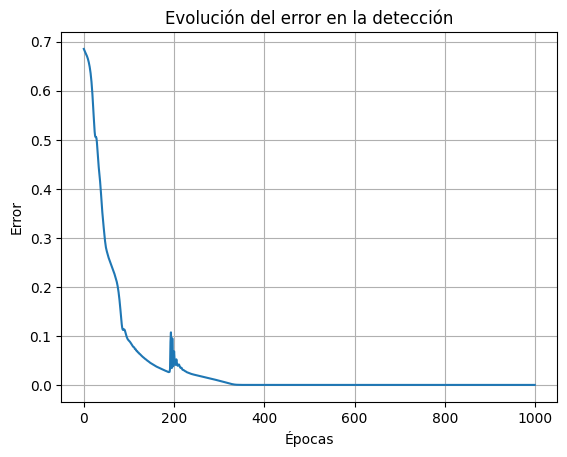

In [8]:
# Perdida
plt.figure()
plt.plot(history)
plt.xlabel("Épocas")
plt.ylabel("Error")
plt.title("Evolución del error en la detección")
plt.grid(True)
plt.show()

In [9]:
# Pasar X_test a tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Forward en modo evaluación
with torch.no_grad():
    logits = mlp(X_test_tensor)          # salida sin sigmoid
    probs = torch.sigmoid(logits)        # probabilidad [0,1]
    pred_labels = (probs >= 0.5).int().numpy().flatten()

# Calcular Accuracy y Reporte
from sklearn.metrics import accuracy_score, classification_report
y_test_true = y_test.flatten()
print(f"Accuracy en Test: {accuracy_score(y_test_true, pred_labels):.4f}")
print(classification_report(y_test_true, pred_labels))


Accuracy en Test: 0.9505
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     16410
         1.0       0.89      0.91      0.90      5218

    accuracy                           0.95     21628
   macro avg       0.93      0.94      0.93     21628
weighted avg       0.95      0.95      0.95     21628



[[15828   582]
 [  489  4729]]


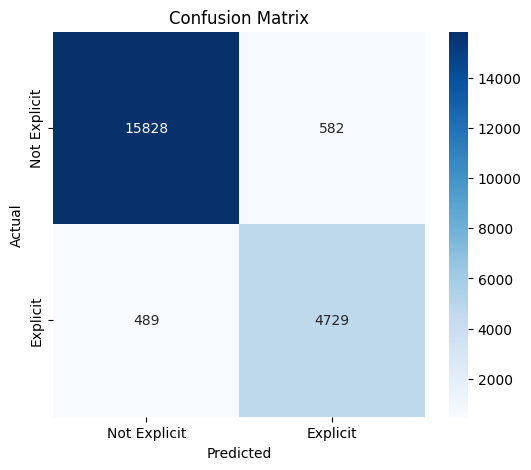

Accuracy:  0.9505
Precision: 0.8904
Recall:    0.9063
F1-score:  0.8983


In [10]:
cm = confusion_matrix(y_test_true, pred_labels)

plt.figure(figsize=(6,5))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Explicit', 'Explicit'], yticklabels=['Not Explicit', 'Explicit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

acc = accuracy_score(y_test_true, pred_labels)
prec = precision_score(y_test_true, pred_labels )
rec = recall_score(y_test_true, pred_labels)
f1 = f1_score(y_test_true, pred_labels)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")